### Project Group 1 in Practical Planning Robust Behavior for autonomous driving
# Reinforcement Learning using Graph Neural Networks

### Tom Dörr, Marco Oliva, Quoc Trung Nguyen, Silvan Wimmer

__Objective__: Implement an reinforcement learning (RL) approach to train a graph neural network (GNN) in the setting of autonomous driving.
## Chapter 0: Setting up
### 0.0: Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib as mpl
import os
import networkx as nx
import time
#import json
#import pickle
#import logging
from collections import OrderedDict
from matplotlib.patches import Ellipse
from IPython.display import clear_output
import random

In [2]:
# BARK imports
from bark.runtime.commons.parameters import ParameterServer
from bark.runtime.viewer.matplotlib_viewer import MPViewer
from bark.runtime.viewer.video_renderer import VideoRenderer

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# BARK-ML imports
from bark_ml.environments.blueprints import ContinuousHighwayBlueprint, \
  ContinuousMergingBlueprint, ContinuousIntersectionBlueprint
from bark_ml.environments.single_agent_runtime import SingleAgentRuntime
from bark_ml.library_wrappers.lib_tf_agents.agents import BehaviorSACAgent, BehaviorPPOAgent, BehaviorGraphSACAgent
#from bark_ml.library_wrappers.lib_tf_agents.runners import SACRunner, PPORunner
from bark_ml.observers.graph_observer import GraphObserver
#from bark_ml.library_wrappers.lib_tf2_gnn import GNNActorNetwork, GNNCriticNetwork

In [4]:
from supervised_learning.data_generation import DataGenerator
from supervised_learning.data_handler import Dataset
from supervised_learning.learner import Learner

### 0.1: Local variables for this notebook

In [5]:
normalization_ref_highway = OrderedDict([('x', [5112.68310546875, 5119.88330078125]),
                                         ('y', [5054.984375, 5304.984375]),
                                         ('theta', [0, 6.283185307179586]),
                                         ('vel', [0, 100]),
                                         ('distance', [0, 250.10366413257154]),
                                         ('dx', [-7.2001953125, 7.2001953125]),
                                         ('dy', [-250.0, 250.0])])

params_path = os.path.join("data", "tfa_params.json")
params = ParameterServer(filename=params_path)
params["World"]["remove_agents_out_of_map"] = False
data_path = os.path.join("data")

visible_distance = params["ML"]["GraphObserver"]["VisibilityRadius", "", 50]

In [6]:
bark_path = os.path.join("/home", "silvan", "working_bark")
bark_path

'/home/silvan/working_bark'

### 0.2: Local functions (will be transfered to helper_functions.py, but easier prototyping here)

In [7]:
from docs.report.helper_functions import visualize_graph

## Chapter 1: Reinforcement learning setting
- what learning setting we have (observation, action, reward)
- SAC approach with actor net outputting distributions of actions and critic net
- ...

Observation space has shape (127,) 
with minimum value 
[ 0.  0.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.] 
and maximum value 
[100. 100. 100.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.  

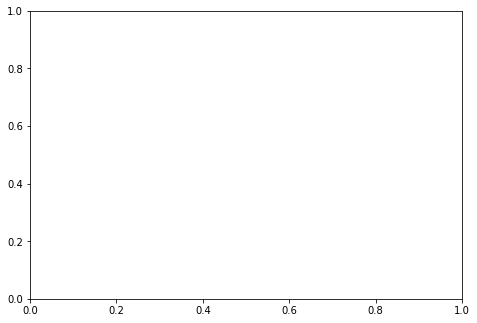

In [8]:
graph_generator = DataGenerator(num_scenarios=3, dump_dir=data_path, params=params)
print('Observation space has shape {} \nwith minimum value \n{} \nand maximum value \n{}'.format(graph_generator.env.observation_space.shape, graph_generator.env.observation_space.low, graph_generator.env.observation_space.high))
print('Action space has shape {}\n with minimum value \n{}\nand maximum value \n{}'.format(graph_generator.env.action_space.shape, graph_generator.env.action_space.low, graph_generator.env.action_space.high))


In the reinforcement learning problem, the observation of environment has size of **3**+**agent_limit** x **feature_len** + size(**adjacency_matrix**), in which: 
- **agent_limit** is the maximum number of agents that can be observed
- **feature_len** is number feature per agent 
- **adjacency_matrix** represent relation between one agent with other agents, which has size **agent_limit** x **agent_limit** 
- the first three components are maximum number of agents, actual number of agents and number of feature per agent

In this case, **agent_limmit** = 12 and **feature_len** = 11

The action has size of 2, which represent the steering and acceleration of agent, respectively

The reward is assigned as follows: 
 - If the agent reaches goal, it receives reward of 1
 - If the agent crashes, it receives reward of -1
 - For each time step that the agent does not crash, it receives a reward of 0.01
 
Our project implements the Soft Actor Critic algorithm for solving the reinforement learning problem. It consists of two different network: 
  - The **Critic network** receives observation and action as inputs and tries to approximate the action-value function $Q_{\phi_i}(s,a)$ to the true action-value function $Q^{\pi}(s,a)$. More specifically, it tries to minimize the error between approximated and target value function
  \begin{equation}
  L(\phi_i, {\mathcal D}) = \underset{(s,a,r,s',d) \sim {\mathcal D}}{{\mathrm E}}\left[
    \Bigg( Q_{\phi_i}(s,a) - y(r,s',d) \Bigg)^2
    \right]
  \end{equation}

    
    
    where the target is given by 
   \begin{equation}
    y(r, s', d) = r + \gamma (1 - d) \left( \min_{j=1,2} Q_{\phi_{\text{targ},j}}(s', \tilde{a}') - \alpha \log \pi_{\theta}(\tilde{a}'|s') \right), \;\;\;\;\; \tilde{a}' \sim \pi_{\theta}(\cdot|s')
   \end{equation}

    
  - The **Actor network** receives observation as inputs and tries to predict the optimal action, which maximize the expected future return plus expected future entropy
  \begin{split}
V^{\pi}(s)&= E_{a \sim \pi}[{Q^{\pi}(s,a)} + \alpha H\left(\pi(\cdot|s)\right)] \\
 &= E_{a \sim \pi}[{Q^{\pi}(s,a) - \alpha \log \pi(a|s)}]
\end{split}

 

## Chapter 2: Observervation of graph data - GraphObserver
- generate some dummy data to show graph observation
- explain a single observation

In [9]:
scenario_data = graph_generator.run_scenarios()
# Window popping up due to MPViewer of BARK lib - not our fault!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

INFO:root:Running data_generation on scenario 1/3


TypeError: graph() missing 1 required positional argument: 'graph_dims'

In [ ]:
# Select random data_point from data_set
data_point = random.choice(random.choice(scenario_data))
observation = data_point["graph"]
graph = GraphObserver.graph_from_observation(observation)

# Visualize datapoint (graph data)
fig = plt.figure(figsize=(4,9))
ax  = fig.add_subplot(111)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
visualize_graph(data_point, ax, visible_distance, normalization_ref_highway)

The image from above shows the perceived environment from the agent's perspective in graph structure:
- the red node is the $\color{red}{\text{controlled/ego agent}}$
- the blue agents are $\color{blue}{\text{other agents which are not controlled}}$
- the yellow zone indicates the <mark>area that agents are visible to the ego agent<mark>. Visibility is further indicated by the missing connections to agents outside the zone
- the green point shows the $\color{green}{\text{goal of the ego agent}}$

About every other agent that the ego agent is perceiving (and about itself) the following information are represented in the individual node features:
- Position -> $x$ and $y$-Coordinates
- Orientation -> $\theta$
- Velocity -> $v$
- Information related to the goal:
    - Position of goal -> $x_{goal}$ and $y_{goal}$-Coordinates
    - Distance to goal -> $dx$ and $dy$ and $d=\sqrt {dx²+dy²}$
    - Necessary orientation at goal position -> $\theta_{goal}$
    - Necessary velocity at goal position -> $v_{goal}$
    
The following cell shows the keys under which the node_features are accessible:

In [ ]:
node_features = graph.nodes[1].keys()
node_features

## Chapter 3: Graph Neural Networks

Before diving into how we apply graph neural networks to our problem, let's have a **very brief** overview about the idea behind them.  
Most importantly, they operate on graph structured data, i.e. data consisting of 
- **Node:** a feature vector (node embedding) of some data entity (and optionally a label), in our case each vehicle is a node
- **Edges:** specified links between nodes
- **Edge features:** optionally, each link between nodes can have its own feature vector

In the section about the `GraphObserver` above, we've already seen how this graph can look like in our scenario. Let's take a step back and use a simplified visualization where the green node represents the ego vehicle and the remaining nodes are other vehicles in its vecinity on the road.

![Schematic view of a GNN](images/simple_gnn.png)

The ego node is connected to both other nodes (it "sees" the other nodes) which in turn do not see each other.

Now, the nodes send messages (their current embeddings) along all outgoing links (here, all links are bidrectional), propagated through a neural network. From now on, we refer to this neural network as the _message passing layer(s)_.

> **NOTE**  
All edges share the same neural network, instead of each edge having its own weights.

Each node aggregates all incoming messages using an aggregation function, like summing or averaging. The result is then processed by another neural network, e.g. a recurrent unit, which computes the new embedding of the node.


In our project, we have integrated two different libraries that offer GNN implementations:
1. [tf2_gnn](https://github.com/microsoft/tf2-gnn): the library that was initially planned to be used in the project
2. [Spektral](https://graphneural.network/#installation): a library that supports edge features, which `tf2_gnn` does not

In summary, the node embeddings are updated as follows (exemplary):

```python
embeddings = recurrent_unit(embeddings, sum(edge_mlp(neighbor_embeddings)))
```
or

$$h_{i,t} = \mathrm{g} \big(h_{i, t-1}, \sum^{N_{i, t}}_j \mathrm{f}(n_{j,t-1}) \big)$$ where $h_{i,t}$ is the embedding of node $i$ at time $t$, $\mathrm{g}$ may be a gated recurrent unit at the nodes, $N_{i, t}$ is the number of neighbors (incoming edges) of node $i$ at time $t$, $n_j$ are the neighbors and $\mathrm{f}$ is a simple feed-forward neural network on the edges.

## Chapter 4: The `GNNWrapper` class

As an abstraction over the specific implementation of the graph neural network, we implemented a wrapper class called `GNNWrapper`. Its primary function is to act just as a GNN and so the only interface is the `call` function that accepts a batch of observations (array representations of graphs) and returns a batch of updated node embeddings for each graph.

In order to support `tf2_gnn` and `Soektral`, we have two distinct call implementations, one for each library. The `GNNWrapper` class decides which one to call based on the arguments given in the initialization.

Both functions however work almost the same:
1. Convert the given observations into nodes, edges and, when using spektral, edges features.
2. Call the respective library with the converted graph representation

When specifying `Spektral` as the GNN library, the call function looks like this:

In [ ]:
from spektral.layers import EdgeConditionedConv, GlobalAttnSumPool
from tensorflow.keras.layers import Dense

# define the layers of the GNN (normally, this happens in the __init__ function)
edge_convolution = EdgeConditionedConv(channels=64, kernel_network=[256], activation="tanh")
pooling = GlobalAttnSumPool()
dense = Dense(units=256, activation="tanh")

def call_spektral(self, observations, training=False):
    # convert the observations into
    # X: tensor containing the node features
    # A: binary adjacency matrix specifying edges in the graph
    # E: tensor containg edge features
    X, A, E = GraphObserver.graph(observations, self._graph_dims)
    
    # pass the inputs through an edge conditioned convolution
    # layer and receive new node embeddings
    X = edge_convolution([X, A, E])
    
    # perform a global pooling operation over the node embeddings
    X = pooling(X)
    
    # pass the noe embeddings through a dense layer
    X = dense(X)
    
    # output the final transformed node embeddings
    return X


# uncomment the following line to call the function with sample observations
#call_spektral(get_sample_observations())

In comparison, when `tf2_gnn` is specified, the implementation looks like this:

In [ ]:
from tf2_gnn.layers import GNN, GNNInput
import pprint as pp

# the number and types of layers in the GNN are all encoded
# in the parameters dictionary
gnn_params = GNN.get_default_hyperparameters()

# uncomment the following two lines to have a look at them
#print(f'GNN parameters:')
#pp.pprint(gnn_params)

# initialize a GNN instance which acts as a keras layer
gnn = GNN(gnn_params)

def call_tf2_gnn(self, observations, training=False):
    batch_size = tf.constant(observations.shape[0])
    
    # convert the observations into
    # X: tensor containing the node features
    # A: dense adjacency list in the format [[0, 1], [2, 4]]
    #    specifying source and target node ids of an egde
    # node_to_graph_map: a tensor that assigns each node in X to a graph
    X, A, node_to_graph_map = GraphObserver.graph(
      observations, 
      graph_dims=self._graph_dims, 
      dense=True)

    gnn_input = GNNInput(
      node_features=X,
      adjacency_lists=(A,),
      node_to_graph_map=node_to_graph_map,
      num_graphs=batch_size,
    )

    return self._gnn(gnn_input, training=training)

# uncomment the following line to call the function with sample observations
#call_tf2_gnn(get_sample_observations())

Having the GNN functionality nicely abstracted behind this wrapper, we can now easily integrate it into the Soft-Actor-Critic framework.

## Chapter 5: The Soft-Actor-Critic Algorithm with Graph Neural Networks

Next, let's examine the integrated system.

Above, we have already discussed how the **Soft-Actor-Critic** algorithm works on a high level and how the SAC-agent is integrated into **BARK-ML**. In our case, we want to exploit the graph-like structure of traffic scenarios and have already encoded the state of the world as a graph. Now, we want to apply graph neural networks to the SAC algorithm. 

The resulting actor and critic networks are quite similar in structure. Here's how they work and what they compute.

### The Actor Network

**Input**: a batch of observations of shape _(batch_size, observation_size)_  
**Output**: a batch of a normal distributions over the action space from which the policy will sample the actions performed by the agent

![Actor Network Architecture](images/actor_architecture.png)

**1. GNN**  
The observations are directly fed into the graph neural network (a `GNNWrapper` instance). It converts the observations into graphs and computes new node embeddings for each graph by means of message passing and aggregation. Depending on which GNN library is selected, these embeddings are flattened with a either a pooling (`spektral`) or a global exchange (`tf2_gnn`) layer and finally propagated through a dense layer that outputs flattened graph representations.

> **NOTE**  
From here on, we're only interested in the embeddings of the ego agent. Hence, instead of feeding the whole graph representation into the encoding network, we extract the embeddings of the first node of each graph, which represents the ego agent.

**2. Encoding Network**  
In the encoding network, the node embeddings of the ego agent are now passed through a series of dense layers. Depending on the parameters passed into the actor, we can also add convolutions, dropout and other types of layers here.

**3. Projection Network**  
Finally, the projection network receives the hidden representations after the encoding network and computes a normal distribution over the action space for each observation contained in the batch, modeled by a mean and a standard deviation.

In a very simplified manner for brevity, the implementation of the actor's `call` function looks as follows:
```python
def call(self, observations, training=False):
    batch_size, feature_len = observations.shape
    
    # get the updated node embeddings
    output = self._gnn(observations, training=training)

    # extract the ego state (the first node embedding vector of each batch element)
    output = output[:, 0]
    
    # pass the ego agent's node embeddings through the encoder
    output = self._encoder(output, training=training)
    
    # compute a normal distribution
    output = self._projection_net(output, training=training)

    return output
```

### The Critic Network

**Input**: a batch of observation-action pairs, i.e. `[obs, action]` with shapes _(batch_size, observation_size)_ and _(batch_size, 2)_  
**Output**: a scalar value assigned to each observation-action pair

![Critic Network Architecture](images/critic_architecture.png)

The major difference compared to the actor network is that in the critic, we have two parallel pipelines for the observations and their corresponding actions.

**1. Actions**  
The actions are simply passed into an action encoding network that works similar to the encoding network of the actor network, i.e. a series of dense layers with optional convolutions, dropout layers, etc.

**2. Observations**  
The observations are processed in the exact same way as in the actor network. We compute new graph representations in the GNN, extract the ego node embeddings and pass them through an encoding network.

**3. Joining Actions and Observations**  
After receiving the outputs from the action and observation encoding networks, we concatenate the observation-action pair of each element in the batch to one feature vector.  
Finally, we pass this concatenated state through a fully connected joint network which outputs a scalar value for each observation-action pair.

Again, a simplified version of the implemenation looks like this:
```python
def call(self, inputs, training=False):
    observations, actions = inputs
    batch_size = observations.shape[0]
     
    # get the updated node embeddings
    node_embeddings = self._gnn.batch_call(observations, training=training)
    
    # extract the ego state (the first node embedding vector of each batch element)
    output = output[:, 0]
    
    # pass the node embeddings through their observation encoder
    node_embeddings = self._observation_encoder(node_embeddings, trainig=training)
    
    # do the same for the actions with a different action encoder
    actions = self._action_encoder(actions, training=training)
    
    # concatenate observations and actions into one vector
    joint = tf.concat([node_embeddings, actions], 1)
    
    # compute a scalar output value
    output = self._joint_net(joint, training=training)

    return output, network_state
```

## Chapter 6: Evaluation of capabilites of actor net
- introduce supervised setting
- benchmark GNN-SAC vs SAC, randomActor and ConstantActor

In [ ]:
#to do 

## Chapter 7: Summary

## Apendix: Commands 

In [ ]:
os.getcwd()

# Run bazel commands from here (no visualizations)

In [ ]:
!pwd

!cd /home/silvan/working_bark && bazel run //examples:tfa

In [ ]:
!cd /home/silvan/working_bark && bazel run //examples:tfa